# Python'da Duygu Analizi
VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words yaklaşımı

1. VADER, özellikle sosyal medya metinleri gibi kısa ve bilgilendirici metinlerin duygu analizini yapmak için geliştirilmiş bir duygu analiz aracıdır. VADER, kelimelerin ve ifadelerin önceden belirlenmiş bir duygu sözlüğünü kullanarak, metinlerin duygusal tonunu değerlendirir. 
* 1. Bag of Words Yaklaşımı: VADER, metni kelime torbası (bag of words) modeliyle analiz eder. Bu modelde, kelimeler ve ifadeler bağımsız olarak değerlendirilir ve metnin genel duygu puanı bu değerlendirmelerin toplamıyla belirlenir.

# Adım 1.
* Verisetimizi okumak
* Gerekli kütüphanelerin importunu gerçekleştirmek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


In [2]:
#Verisetimizi okuma
df = pd.read_csv('Reviews.csv')
print(df.shape)
print(len(df['Id']))
df = df.head(2000)

(568454, 10)
568454


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

## Quick EDA

In [5]:
#Puan dağılımını gösterme
df['Score'].value_counts()

Score
5    1303
4     254
1     178
3     162
2     103
Name: count, dtype: int64

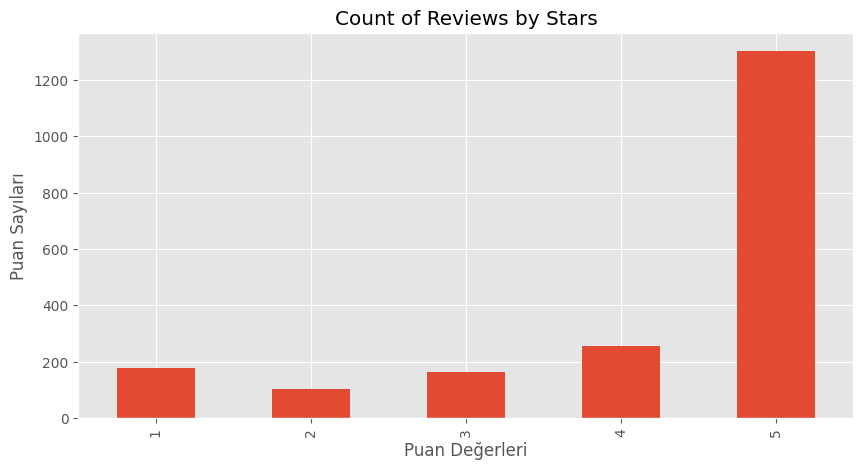

In [6]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar' , title="Count of Reviews by Stars" , figsize=(10,5))

ax.set_xlabel('Puan Değerleri')
ax.set_ylabel('Puan Sayıları')
plt.show()

## Basic NLTK

In [7]:
import nltk 
# Gerekli NLTK veritabanlarını indir
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kursa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kursa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
#Part-of-Speech tagging yöntemi
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\kursa\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kursa\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [12]:
#Named Entity Recognition (NER) yöntemi
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Adım 1.VADER Duygu Puanlaması
### Metnin negatif/nötr/pozitif puanlarını almak için NLTK'nin SentimentIntensityAnalyzer'ını kullanacağız.
* Bu, "bag-of-words" yaklaşımını kullanır:
    1. Durdurma kelimeleri çıkarılır
    2. Her kelime puanlanır ve toplam bir puana dönüştürülür.

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kursa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [16]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [17]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [18]:
#Tüm veriseti üzerinde polarity scoreu saklamak için bos bir dict olusturma
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text'] #her bir satırdaki 'Text' versini alır ve 'text' değişkenine atar.
    myid = row['Id'] #her bir satırdaki 'Id' degerini alır ve 'myid' değişkenine atanır.
    res[myid] = sia.polarity_scores(text) #her bir text'in duyusal analizi yapilir ve res dictinin myid indexine göre saklanır.

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
print(res)

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}, 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}, 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265}, 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468}, 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}, 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346}, 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487}, 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369}, 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313}, 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746}, 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579}, 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296}, 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466}, 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486}, 16: {'neg': 0.0

In [20]:
vaders = pd.DataFrame(res).T #res dictini kullanarak bir pandas DataFrame olusturur.
vaders = vaders.reset_index().rename(columns = {'index':'Id'}) #Olusturulan DataFrame'in 'index'->'Id' olarak degistirir.
vaders = vaders.merge(df , how='left') #Olusturulan DataFrame ile orjinal DataFrami birlestirir.

In [21]:
#Simdi SolarityScorelar'i ve metadatalarımız aynı DataFrame'e yerlestirdik
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## NOT:
* Simdi bu Frameworke bakarak bazi varsayimlarda bulunabiliriz.
* Örneğin '5 puanlı bir yorum muhtemelen daha pozitiftir' yaklaşımını kullanacağız.

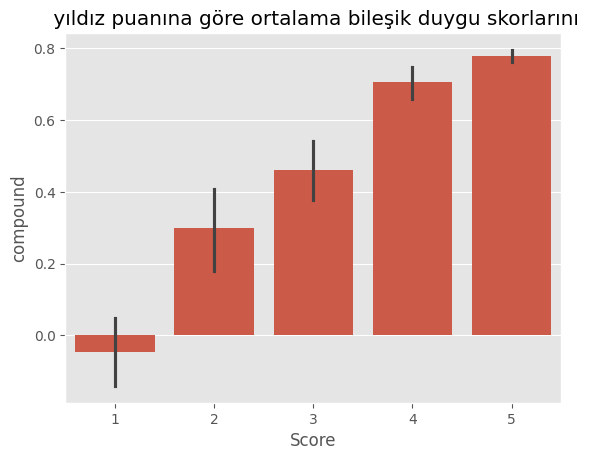

In [22]:
#Duygu skorlarının görselleştirilmesi
ax = sns.barplot(data=vaders, x='Score', y='compound') #compound = ortalama bileşik duygu değeri
ax.set_title(" yıldız puanına göre ortalama bileşik duygu skorlarını")
plt.show()

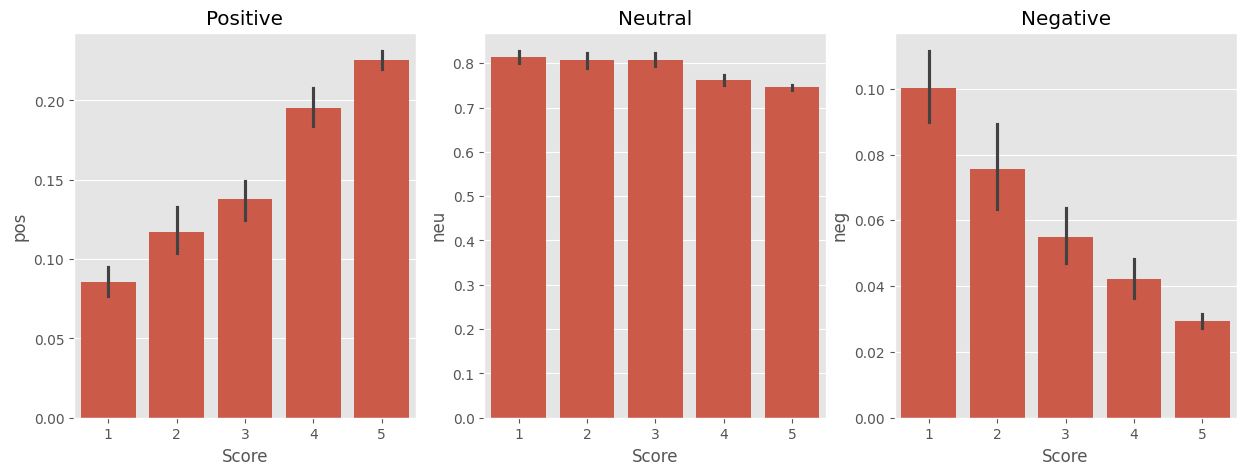

In [23]:
#Pozitif, nötr ve negatif duygu skorlarını yıldız puanına göre ayrı ayrı gösterme
fig, axs = plt.subplots(1, 3, figsize=(15,5)) #fig tüm grafik , axs->alt grafikleri belirtir.
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()